# Week 12: Unsupervised Learning 

## Dimensionality Reduction

## a Brief Recap:

* Hello, how are you?
* Today: Dimensionality Reductions, Unsupervised Learning Methods for Numeric Targets
* Next week: Culstering, Unsupervised Learning for Categorical Targets

## Unsupervised Learning

What if we have some data in the form of a feature space, but no information on the target variable?  

Unsupervised Learning Methods do not get feedback on a target, rather, unsupervised learning seeks to discover patterns in the features provided.  

#### Families of Unsupervised Methods:  

* Dimensionality Reduction 
    - PCA - principle component analysis
    - LDA - linear discirminant analysis
    - SVD - singular value decomposition
* Clustering
    - k-Means
    - Hierarchical lustering
    - Gaussian Mixture Densities
* Non-parametric
    - kernel estimators

## Dimensionality Reduction

Reducing the dimensionality (degrees of freedom) of a dataset.

### The Curse of Dimensionality: The same amount of feature space holds fewer observations

<img src="https://eranraviv.com/wp-content/uploads/2016/01/COD.png" width="55%" style="margin-left:auto; margin-right:auto">

### The Curse of Dimensionality: Sampling more feature space is required to describe the same amount of observations

<img src="https://www.visiondummy.com/wp-content/uploads/2014/04/curseofdimensionality.png" width="70%" style="margin-left:auto; margin-right:auto">

[computer vision for dummies link](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)

### Why reduce the dimension space; isn't more information better?  

* high dimensional datasets are very sparse!
* remove uninformative features to increase the power of inferences made during testing
* simple models are more robust, because the performance varies less
* simple models are easier to interpret

### How to reduce the dimension space

* **feature selection** - if all features are independent, use a criteria to subset features relevant to the model
    - ex: forward or backward features selection
* **feature extraction** - finding a new set of dimensions that are derived from the dataset features
    - **Projection** - find a subspace of the features that explains as much of the variance as possible
    - **Manifold Learning** - a [**manifold**](https://scikit-learn.org/stable/auto_examples/manifold/plot_swissroll.html) is a higher dimensional distribution that locally resembles a lower dimensional hyperplane. manifold learning assumes that high dimensional data can be described by a lower dimensional manifold

## PCA

**PCA** - Principle Component Analysis. We are interested in finding a mapping from the original dataset feature space with $d$ degress of freedom to a new space with $k$ degrees of freedom where $k\lt d$; we would like to minimize the loss of information in the process

* map to a smaller feature space
* try to preserve information
* obtain the uncorrelated components of the features

### Preserving Variance

PCA works by finding a hyperplane that lies closest to the data.

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2016/03/2-1-e1458494877196.png" width="70%" style="margin-left:auto; margin-right:auto">


### Choosing the Right Hyperplane

We would like to:  

* idenitify the axis that accounts for most variance
* this will also minimize the minimize the mean squared distance of the original data onto the new axis

Before we dive too deep into PCA, let's meet the dataset we will be working with....

## Spike Waveforms

Import and visualize spike waveform data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [5]:
url = 'https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/datasets/waveforms.csv'
waveforms = pd.read_csv( url, index_col = 'uid' )
waveforms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651 entries, VT007_066B to AP026R_054G
Columns: 151 entries, 0 to organoid
dtypes: float64(150), object(1)
memory usage: 773.1+ KB


In [7]:
waveforms.organoid.value_counts()

AP_drug           163
TSCp5_32s         120
TSCp5_30s         103
AP_ctrl           102
DLX_Cheriff        65
TSCp5_32s_CHIR     46
DLX_bluered        32
TSCp5_30s_CHIR     13
DLX_H9              7
Name: organoid, dtype: int64

In [45]:
wf_features = waveforms.drop(['organoid'], axis = 1, inplace = False )
organoids = waveforms.organoid.unique()
print( organoids )

['DLX_Cheriff' 'DLX_bluered' 'DLX_H9' 'TSCp5_32s_CHIR' 'TSCp5_32s'
 'TSCp5_30s' 'TSCp5_30s_CHIR' 'AP_drug' 'AP_ctrl']


In [43]:
def plot_waveforms( df, index_list, mat_dim=5):

    fig, ax = plt.subplots(mat_dim, mat_dim, figsize=(8,8))

    for idx, im_idx in enumerate( index_list ):
        some_waveform = np.array( df.iloc[im_idx] )
        plt.subplot( mat_dim,mat_dim,idx + 1 )
        plt.plot(some_waveform, color = 'black')
        plt.axis( 'off' )
    #plt.show()

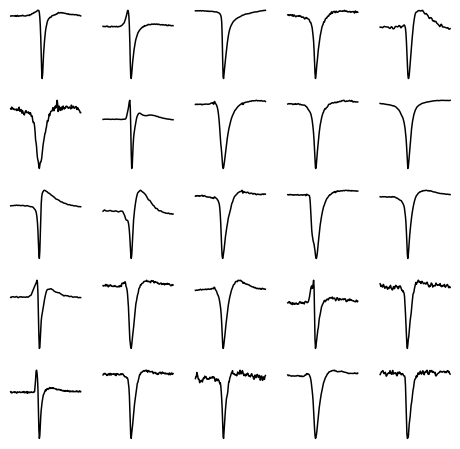

In [46]:
num_plots = 5
rand_waveforms = np.random.choice(range(wf_features.shape[0]), size = num_plots**2, replace = False)
plot_waveforms( wf_features, rand_waveforms)

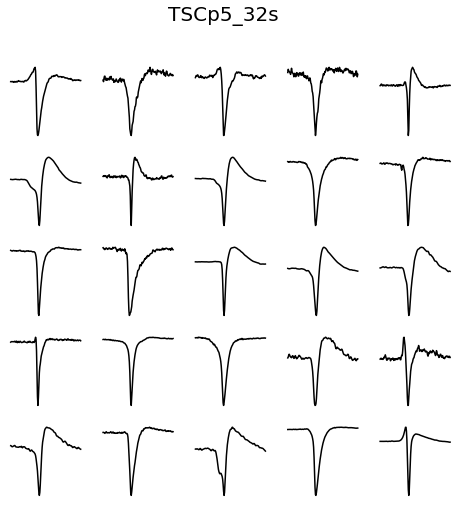

In [47]:
# plot similar waveforms
idx = 4
choice_organoid = organoids[idx]
organoid_df = waveforms[ waveforms['organoid']==choice_organoid ]
organoid_plot = waveforms.drop(['organoid'], axis = 1, inplace = False )

rand_waveforms = np.random.choice(range(organoid_plot.shape[0]), size = num_plots**2, replace = False)
plot_waveforms( organoid_plot, rand_waveforms)
plt.suptitle(organoids[idx], fontsize = 20)
plt.show()

## Dimensionality Reduction of Spike Waveforms

We have a collection of waveforms each with 150 features (samples). We want to use PCA to reduce this to the smallest number of features that can still account for the most variance in the data so that we can distinguish between cell types. 

Let's talk about PCA in more depth to learn how best to go about this with our spike data...

### PCA Algorithm

PCA is a matrix decomposition that we apply to the features of a dataset

1. Center & Normalize the Data
2. Calculate the Covariance Matrix
3. Perform an Eigendecomposition
4. Obtain the projections of the data (Components)

## 1) Center & Normalize the Data

1. Center -> demean the data so that the mean of each feature == zero
2. Normalize -> scale the data to have unit variance

In [52]:
from sklearn.preprocessing import StandardScaler
wf_scaled = StandardScaler().fit_transform( wf_features )

## 2) Calculate the Covariance Matrix



In [55]:
wf_features = wf_scaled.T
cov_matrix = np.cov(wf_features)

The result is a square symmetric matrix  
The variance of each feature is given along the diagonal  
The covariances between all features are given off the diagonal  

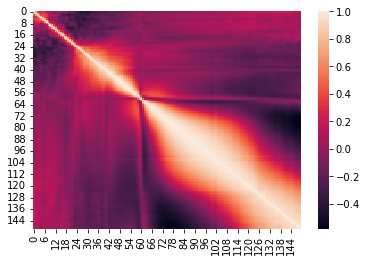

In [57]:
sn.heatmap(cov_matrix, annot=False, fmt='g')
plt.show()

## 3) Perform an Eigendecomposition

decompose the covariance matrix into simple unit vectors (eigenvector) and associated coefficients/magnitudes (eigenvalues)

In [58]:
# perform the eigendecomposition
values, vectors = np.linalg.eig(cov_matrix)

In [61]:
# calculate the percentage of variance explained by each component
explained_variance = [ values[i] / np.sum(values) for i in range( len( values ) ) ]

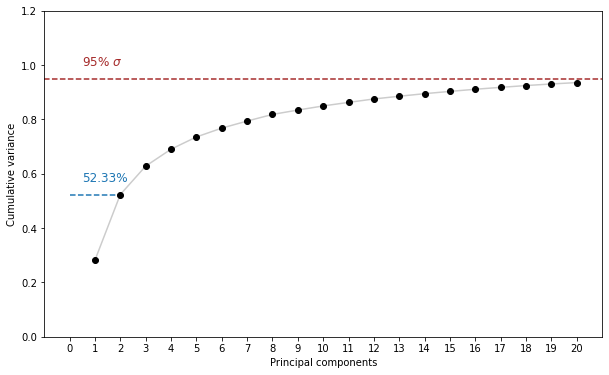

In [78]:
# plot the amount of
csum_values = values.cumsum()/values.shape[0]

N_components = 20
x = np.arange(1, N_components+1, step=1)
y = csum_values[0:N_components]

def plot_cvar( x, y, num_C ):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(x, y, '-', color='gray', alpha = 0.4)
    plt.plot(x, y, 'o', color='k')
    plt.ylim(0.0,1.2)
    plt.xlabel('Principal components')
    plt.xticks(np.arange(0, N_components + 1, step=1))
    plt.ylabel('Cumulative variance')
    plt.axhline(y = 0.95, color = 'brown', linestyle = '--')
    plt.hlines(y = y[1], xmin = 0, xmax = 2, color = 'C0', linestyle = '--')
    plt.text(0.5, 1, '95% $\sigma$', color = 'brown', fontsize=12)
    plt.text(0.5, y[1]+0.05, s=f'{y[1]*100:1.2f}%', color = 'C0', fontsize= 12)

plot_cvar( x,y,N_components)

### Obtain the Components

In [136]:
projection_1 = wf_scaled.dot(vectors.T[0])
projection_2 = wf_scaled.dot(vectors.T[1])
projection_3 = wf_scaled.dot(vectors.T[2])
res = pd.DataFrame(projection_1, columns=['PC1'])
res['PC2'] = projection_2
res['PC3'] = projection_3
res.head()

,PC1,PC2,PC3
0,-2.088232,4.919215,1.493662
1,-4.842392,-0.797512,-2.059672
2,-2.666606,1.622787,-0.236874
3,1.728001,1.910773,5.812638
4,-8.084174,-1.225774,-8.690275


## PCA by way of `sklearn`

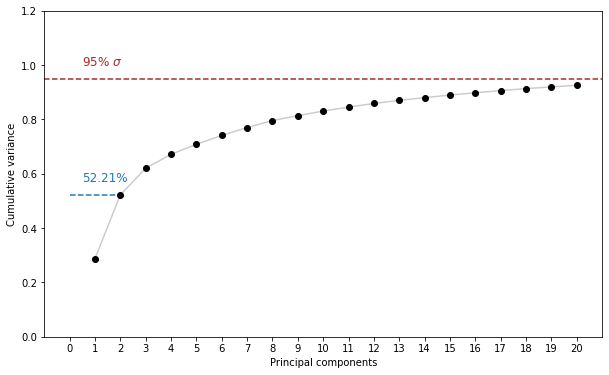

In [79]:
from sklearn.decomposition import PCA
sklpca = PCA( n_components=N_components )
wf_sklpca = sklpca.fit( wf_features )
y = np.cumsum( sklpca.explained_variance_ratio_ )
plot_cvar( x,y,N_components)

## improving....

If we look at the waveforms that we plotted previously, we can see that there is some baseline leading the waveforms. Let's drop ~25 ms (first 25 features) and see how this affects the PCA

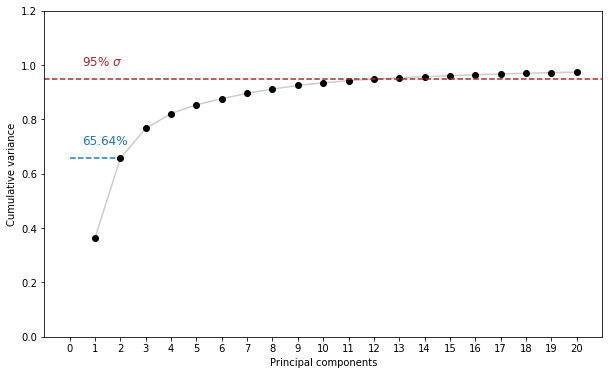

In [88]:
wf_dropbaseline = wf_features[25:]
sklpca = PCA( n_components=N_components )
wf_sklpca = sklpca.fit( wf_dropbaseline )
y = np.cumsum( sklpca.explained_variance_ratio_ )
plot_cvar( x,y,N_components)

## Visualizing the first 3 Principle Components

In [124]:
#wf_pcs = sklpca.fit_transform(wf_dropbaseline)
wf_PCAs = pd.DataFrame()
wf_PCAs['PC1'] = wf_sklpca.components_[0]
wf_PCAs['PC2'] = wf_sklpca.components_[1]
wf_PCAs['PC3'] = wf_sklpca.components_[2]
wf_PCAs['organoid'] = waveforms['organoid'].values
wf_PCAs.head()

,PC1,PC2,PC3,organoid
0,0.018421,-0.016039,-0.013108,DLX_Cheriff
1,-0.024765,-0.024360,-0.006856,DLX_Cheriff
2,-0.002902,-0.018602,0.003742,DLX_Cheriff
3,0.016581,0.016169,0.024949,DLX_Cheriff
4,-0.039355,-0.048805,-0.070717,DLX_Cheriff


In [118]:
import plotly.express as px

fig = px.scatter_3d(wf_PCAs, x='PC1', y='PC2', z='PC3', size_max = 5, opacity=0.7)
fig.show()

### Visualize Neurons of Different Tissue Origins

Let's see if we can find PCA patterns based on the tissue origin of spike waveforms....

In [133]:
organoid_idx = 3
organoids[organoid_idx]
wf_PCAs['has_organoid'] = np.where( wf_PCAs['organoid'] == organoids[organoid_idx], 'red', 'blue')
wf_PCAs.head()

,PC1,PC2,PC3,organoid,has_organoid
0,0.018421,-0.016039,-0.013108,DLX_Cheriff,blue
1,-0.024765,-0.024360,-0.006856,DLX_Cheriff,blue
2,-0.002902,-0.018602,0.003742,DLX_Cheriff,blue
3,0.016581,0.016169,0.024949,DLX_Cheriff,blue
4,-0.039355,-0.048805,-0.070717,DLX_Cheriff,blue


In [134]:
fig = px.scatter_3d(wf_PCAs, x='PC1', y='PC2', z='PC3', color = 'has_organoid', size_max = 5, opacity=0.4)
fig.show()

## Next week we'll look at Clustering: Unsupervised Learning for Categorical Targets
<img src="https://content.techgig.com/photo/80071467/pros-and-cons-of-python-programming-language-that-every-learner-must-know.jpg?132269" width="100%" style="margin-left:auto; margin-right:auto">